In [1]:
import os

print('Number of labeled images: ', len(os.listdir('train/')))

Number of labeled images:  220025


0    130908
1     89117
Name: label, dtype: int64

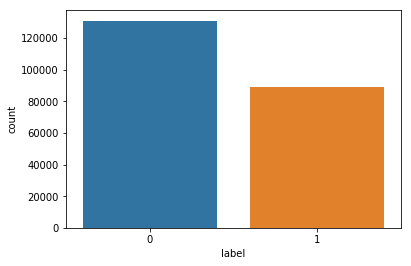

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Class Distribution
df_data = pd.read_csv('train_labels.csv')
g = sns.countplot(df_data['label'])
df_data['label'].value_counts()

In [3]:
# Image ids with labels
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
from sklearn.utils import shuffle

# Class Balance

# take a random sample of class 0 with size equal to number of samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(25000, random_state = 101)
df_1 = df_data[df_data['label'] == 1].sample(25000, random_state = 101)
# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    25000
0    25000
Name: label, dtype: int64

In [5]:
# Load Images
import glob
import numpy as np
import os.path as path
from scipy import misc

image_ids = list(df_data['id'])

file_paths = []
for id in image_ids:
    fname = str(id) + '.tif'
    f = path.join('train/', fname)
    file_paths.append(f)

images = [misc.imread(path) for path in file_paths]
images = np.asarray(images)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


In [6]:
labels = list(df_data['label'])
labels = np.asarray(labels)

print('Data shape: ', images.shape)
print('Lables shape: ', labels.shape)

Data shape:  (50000, 96, 96, 3)
Lables shape:  (50000,)


In [7]:
# Plot some images

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

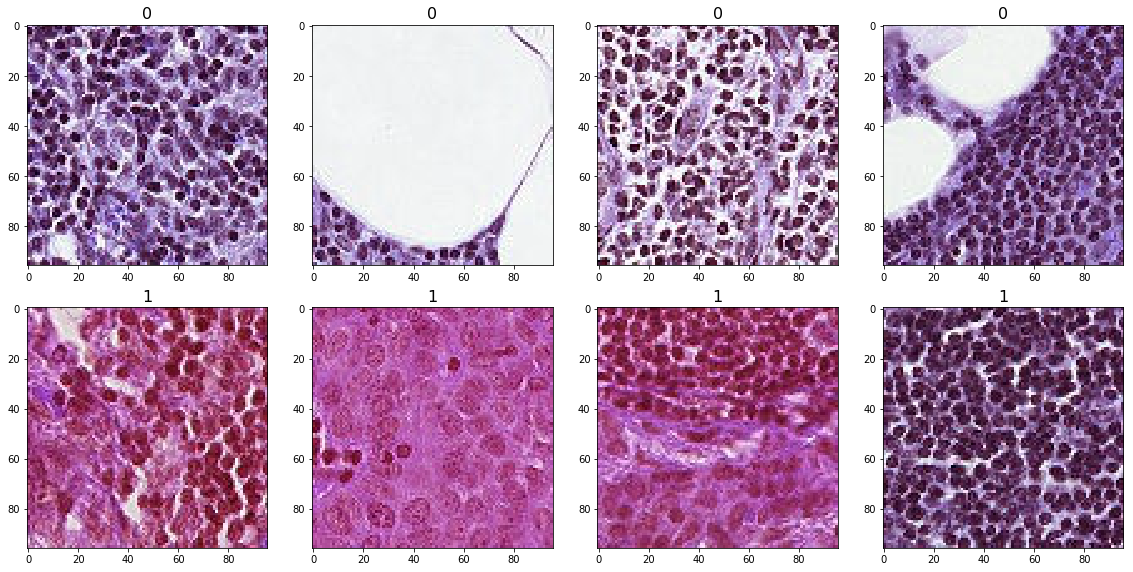

In [8]:
draw_category_images('label',4, df_data, 'train/')

In [9]:
# Split train/test data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=1, stratify=labels)

In [10]:
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (37500, 96, 96, 3)
Training labels shape:  (37500,)
Test data shape:  (12500, 96, 96, 3)
Test labels shape:  (12500,)


In [11]:
# Reshape the image data into rows
x_train = np.reshape(x_train, (x_train.shape[0],-1))
x_test = np.reshape(x_test, (x_test.shape[0],-1))
print(x_train.shape, x_test.shape)

(37500, 27648) (12500, 27648)


In [17]:
# Create logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver = 'sag', penalty = 'l2', multi_class ='ovr')
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)


In [18]:
# Create regularization hyperparameter space
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
hyperparameter = dict(C=C)

In [20]:
# Create grid search using 5-fold cross validation
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(model, hyperparameter, cv=5, verbose =0)

In [21]:
# Fit grid search
best_model = clf.fit(x_train, y_train)

/home/nini/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nini/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nini/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nini/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nini/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the 

In [22]:
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 1.0


In [23]:
best_model.score(x_test, y_test)

0.59744

In [24]:
%store x_train
%store y_train
%store x_test
%store y_test

Stored 'x_train' (ndarray)
Stored 'y_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_test' (ndarray)


Text(0.5, 257.44, 'Predicted label')

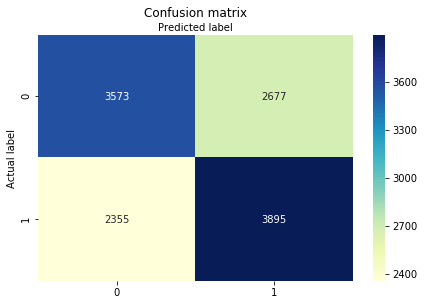

In [26]:
# Classification Matrix
from sklearn import metrics

y_pred = best_model.predict(x_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu", fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')